# Dataset Filtering with Advanced Clustering Techniques 

In this notebook, we want to demonstrate an approach to dataset filtering, useful on face image datasets.
The primary goal is to filter out images based on the quality of the images and the faces templates, allowing for enhanced performance in subsequent face recognition tasks.

## Motivation

Traditional dataset processing methods for face recognition often involve manual annotation and selection, which can be time-consuming and potentially biased.
An automated method can significantly speed up this process while ensuring consistent criteria for image selection.
In the proposed filtering algorithm, we use not only the distances between the face templates, but also the quality of the image itself (see the quality algorithm).
This makes it possible to simplify the selection of hyperparameters of filtration (clusterization) and improve its quality.

## Methodology:

Algorithms used:

- Face Recognition Model: Utilizing the ResNet200 model, a pre-trained deep learning model designed for face recognition tasks. This model used in computing face templates/embeddings.

- Quality Estimation: Using the QualityEstimatorPipeline to assess the quality of face images.


Proposed clustering algorithm:

1. Every face image is transformed into a high-dimensional vector using a pretrained ResNet200 model. Alongside, a Quality Assessment Algorithm (QAA) score is computed, providing a scalar representation of the image's quality.

2. The pairwise distances between embeddings and a matrix representing the minimum QAA scores between image pairs are computed. A connection criterion, based on the difference between these matrices and a predetermined threshold, dictates the edges of the graph.

3. The constructed graph undergoes community detection, using algorithms such as label propagation, greedy modularity, and others, to identify potential sub-clusters or communities within the larger group.

## Experiments

We're using a subset of the glint360k dataset, a popular large-scale face dataset. For the purpose of this demonstration, we'll be working with a selection of 1000 directories from this dataset.


We are comparing the novel filtering technique with traditional methods like DBSCAN. This is visualized using t-SNE, a dimensionality reduction technique, allowing us to observe the clustering of images based on their features.


## Initialization

In [2]:
import os
import sys
sys.path.append("..")
import torchvision
import torch
import numpy as np
import sklearn.manifold
from torchvision.datasets import ImageFolder

from recognition.models.iresnet_custom import iresnet200
from dataset import SelectedImageFolder
from face_dataset_filtering import FaceDatasetFiltering
from visualizations import visualize_tsne, visualize_ith_group, plot_tsne_with_labels

In [3]:
device = 'cuda'

### Loading Face Recognition Model

Load the pretrained weights into the face recognition model and transfer it to our chosen device.

In [4]:
!wget http://download.cvartel.com/facesdk/archives/artifacts/ml/models/iresnet200_weigths.pth -nc -O ../recognition/weights/iresnet200_weights.pth

File ‘./weights/iresnet200_weights.pth’ already there; not retrieving.


In [5]:
weights_path = '../recognition/weights/iresnet200_weights.pth'
face_model = iresnet200(conv_bias=True)
face_model.load_state_dict(torch.load(weights_path, map_location=device))
_ = face_model.to(device).eval()


### Quality Estimator Pipeline Initialization

This will be useful for face image quality assessment.  
If you haven't trained QAA model, you can download it here.

Download weights(backbone.pth) and put it as openhat_ai/recognition/weights/r100_glint360k.pth  
https://onedrive.live.com/?authkey=%21AFZjr283nwZHqbA&cid=4A83B6B633B029CC&id=4A83B6B633B029CC%215698&parId=4A83B6B633B029CC%215582&o=OneUp

In [6]:
!wget http://download.cvartel.com/facesdk/archives/artifacts/ml/models/quality_estimator.cbm -nc -O ../qaa/weights/r100_glint360k_qaa.cbm

File ‘../qaa/weights/quality_estimator.cbm’ already there; not retrieving.



In [7]:
openhat_root = '../'
model_name = "r100_glint360k"
sys.path.append(openhat_root)
import catboost as cb

from qaa.models import BNFeatureExtractor, QualityEstimatorPipeline
from recognition.models.iresnet import iresnet100
qaa_backbone_weights_path = f'../recognition/weights/{model_name}.pth'
qaa_backbone = iresnet100().to(device)
qaa_backbone.load_state_dict(torch.load(qaa_backbone_weights_path, map_location=device))
quality_estimator_weight_path = f"../qaa/weights/{model_name}_qaa.cbm"
quality_estimator = cb.CatBoostRegressor().load_model(quality_estimator_weight_path)

qep = QualityEstimatorPipeline(qaa_backbone, quality_estimator, device=device)

## Dataset Preparation

Setting up the image transformations (used for Quality and FaceRecognition models) and loading the dataset. 
Only a subset of directories are selected from the root directory for processing.

In [11]:
%%sh

if [ ! -d ./glint15k_2 ]; then
    echo "Glint15k_2 not founded! Downloading..."
    wget -nc -q http://download.cvartel.com/facesdk/archives/artifacts/ml/data/glint_15k_2.tar.gz 
    tar -xzf glint_15k_2.tar.gz --skip-old-files
    rm ./glint_15k_2.tar.gz
fi

File ‘glint_15k_2.tar.gz’ already there; not retrieving.



In [12]:
models_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
dataset = ImageFolder("./glint15k_2/", transform=models_transforms)
print(len(dataset))


958761


### Visualizing a Subset of Dataset

Let's have a visual preview of the dataset by visualizing a few images from the first group.


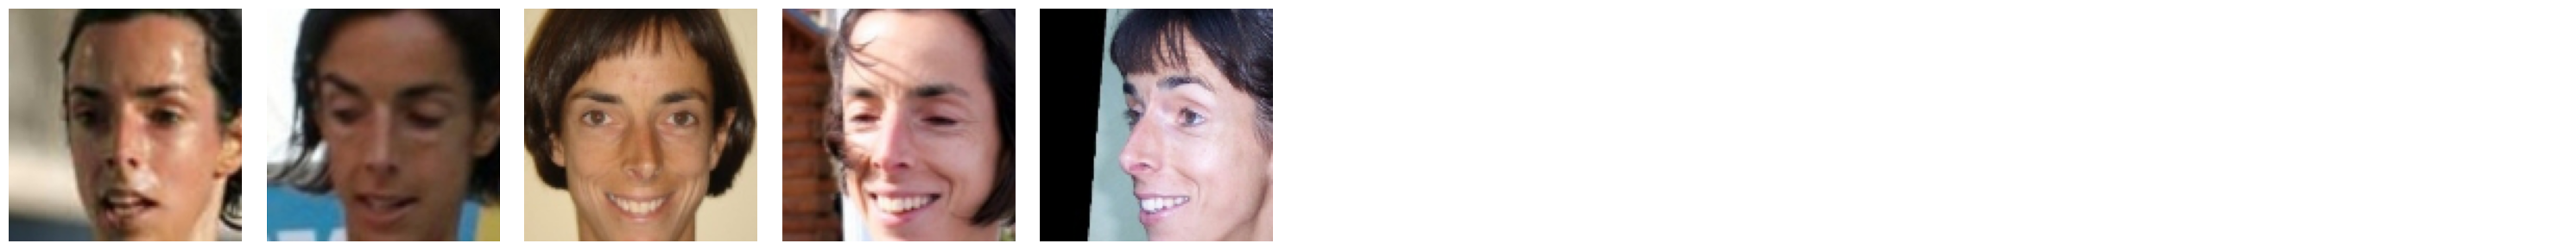

In [13]:
visualize_ith_group(dataset, 100, 10)

## Filtering (clustering) the Dataset

Using the FaceDatasetFiltering class to filter out the dataset based on face recognition model and the quality estimator.


In [14]:
filter_instance = FaceDatasetFiltering(dataset, face_model, qep, device)
filter_instance.filter_dataset()

  0%|          | 0/29962 [00:00<?, ?it/s]

  0%|          | 0/29962 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

In [15]:
# Removing the transformations applied to the dataset (to simplify visualizations).

dataset.transform = None

## Visualizing Clustering Results

Drawing the cluster differences between our new algorithm and the DBSCAN algorithm using t-SNE for dimensionality reduction and visualization.

In [16]:
def draw_cluster_difference(dataset, filter_instance, index):
    indexes = np.where(filter_instance.targets == index)
    emb = filter_instance.embeddings[indexes]
    tsne_res = sklearn.manifold.TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(emb)
    images = [np.array(dataset[i][0]) for i in indexes[0]]

    print('Clustering by new algorithm')
    plot_tsne_with_labels(tsne_res, images, filter_instance.filtering_results[index])

    print('Clustering by DBSCAN algorithm')
    plot_tsne_with_labels(tsne_res, images, filter_instance.filtering_results_dbscan[index])


Clustering by new algorithm


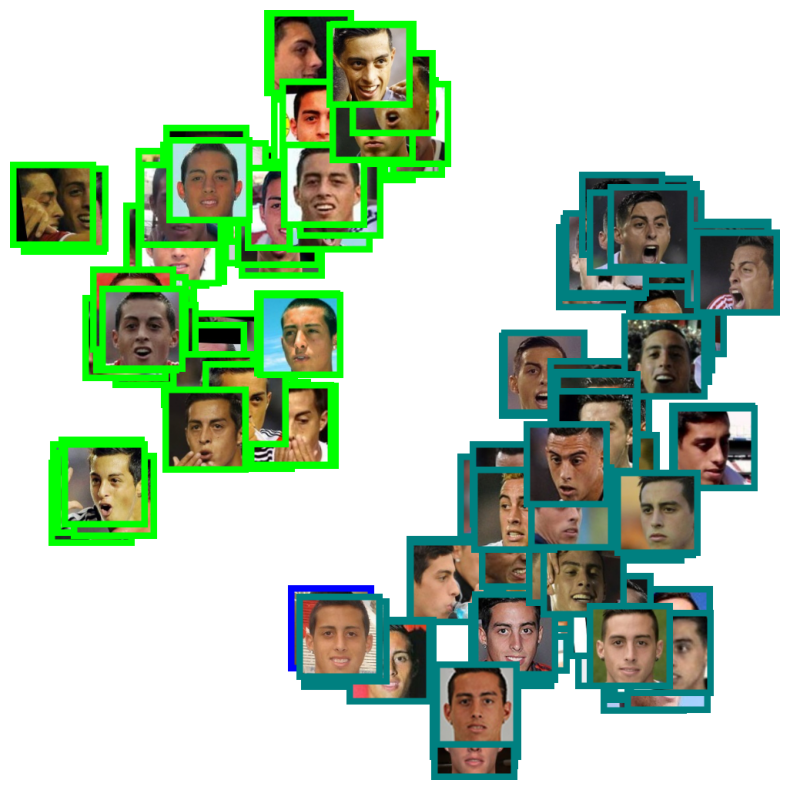

Clustering by DBSCAN algorithm


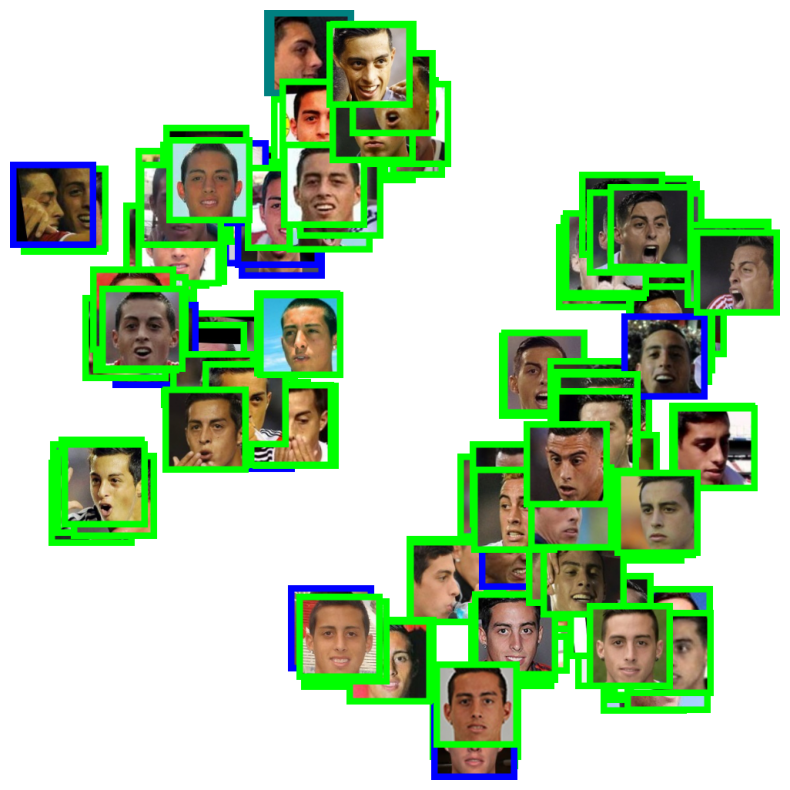

In [17]:
draw_cluster_difference(dataset, filter_instance, 333)

Clustering by new algorithm


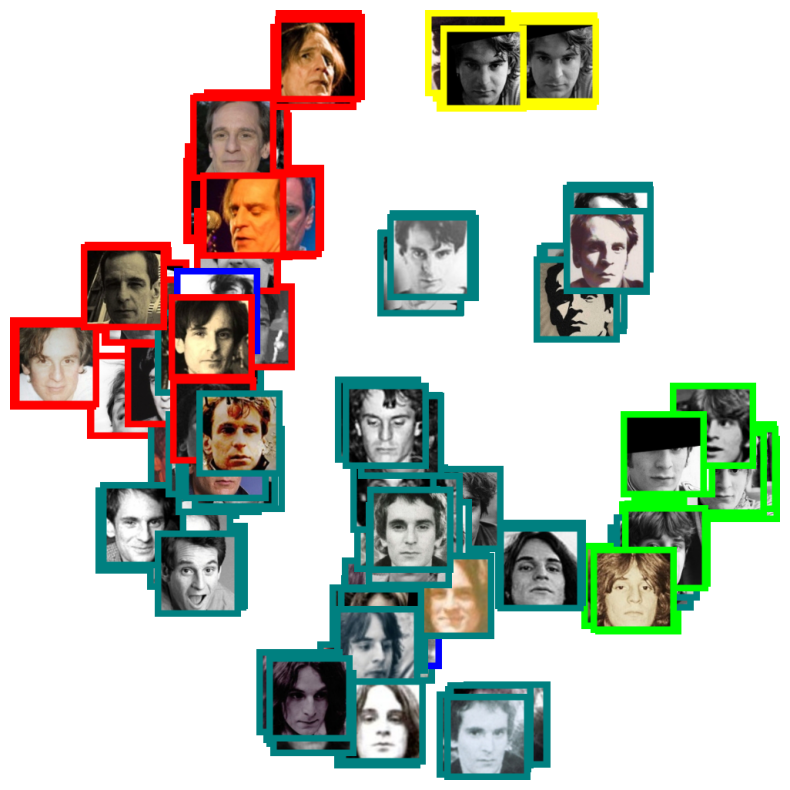

Clustering by DBSCAN algorithm


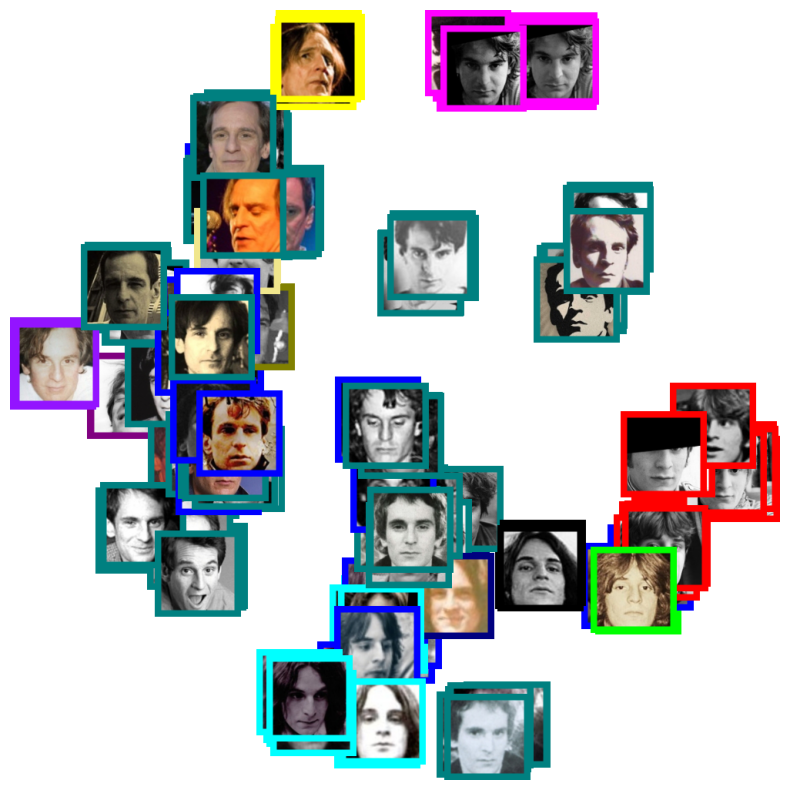

In [19]:
draw_cluster_difference(dataset, filter_instance, 57)